In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold,train_test_split
import matplotlib.pyplot as plt
import pickle
import time
import sys
import os
import gpflow
from gpflow.utilities import print_summary

import sklearn.metrics
import scipy.stats
from tqdm import tqdm

sys.path.append('../../Utils')
from metrics import compute_metrics

import tensorflow as tf

current_dir = os.getcwd()
data_dir = os.path.join(current_dir, '../../../Data/')

RNA_PROT_EMBED = data_dir+'ProcessedData/protein_embeddings/rna_protein_u64embeddings.pkl'

In [2]:
device = 0
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices[device], 'GPU')

print(f'TF eager exectution: {tf.executing_eagerly()}')
print(f'Using device {physical_devices[device]}')

TF eager exectution: True
Using device PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
with open(RNA_PROT_EMBED,'rb') as file:
    rna_prot_embed = pickle.load(file)

In [4]:
cell_lines = list(rna_prot_embed.keys())
print(cell_lines)

['AT2_04M_F0', 'AT2_04M_F10', 'AT2_18M_F0', 'AT2_18M_F10', 'AM_04M_F0', 'AM_04M_F10', 'AM_18M_F0', 'AM_18M_F10']


### Import the genes with missing protein levels feature tables

In [5]:
#mRNA is already log2 transformed
MISSING_PROT = data_dir + 'missing_proteins/rna_missing_protein_u64embeddings.pkl'
with open(MISSING_PROT,'rb') as file:
    rna_missing_prot_embed = pickle.load(file)

#### Log2 transform and zscore function (will need to zscore based of each kfold each iteration)

In [6]:
positions = dict()
for cell in cell_lines:
    positions[cell] = rna_prot_embed[cell][['AvgChrs']]
    rna_prot_embed[cell].drop(columns='AvgChrs',inplace=True)
    rna_prot_embed[cell]['mRNA_TMM'] = np.log2(rna_prot_embed[cell]['mRNA_TMM']+1)
    rna_prot_embed[cell]['ProteinAUC'] = np.log2(rna_prot_embed[cell]['ProteinAUC']+1)
    rna_prot_embed[cell]['ProteinLength'] = np.log2(rna_prot_embed[cell]['ProteinLength']+1)
    
    rna_missing_prot_embed[cell]['seq_length'] = np.log2(rna_missing_prot_embed[cell]['seq_length']+1)
    
def zscore(train_df, test_df,return_means=False):
    assert isinstance(train_df,pd.DataFrame)
    assert isinstance(test_df,pd.DataFrame)
    means = train_df.mean(axis=0)
    stds = train_df.std(axis=0)
    train_zscore = (train_df-means)/stds    
    test_zscore = (test_df-means)/stds
    if return_means:
        return train_zscore, test_zscore, means, stds
    return train_zscore, test_zscore

In [7]:
train_results = pd.DataFrame()
test_results = pd.DataFrame()
ppg_metrics = pd.DataFrame()

for cell in tqdm(cell_lines):
    kf = KFold(n_splits=5,shuffle=True)
    for train_index, test_index in kf.split(rna_prot_embed[cell]):
        try:
            train = rna_prot_embed[cell].iloc[train_index,:]
            train = train.drop(labels='ProteinLength',axis=1)
            test = rna_prot_embed[cell].iloc[test_index,:]
            test = test.drop(labels='ProteinLength',axis=1)

            train_z, test_z = zscore(train,test)
            x_train = train_z.drop(columns='ProteinAUC').values
            y_train = train_z[['ProteinAUC']].values

            x_test = test_z.drop(columns='ProteinAUC').values
            y_test = test_z[['ProteinAUC']].values

            k = gpflow.kernels.SquaredExponential(lengthscale=[1]*x_train.shape[1])

            m = gpflow.models.GPR(data=(x_train, y_train), kernel=k, mean_function=None)
            m.likelihood.variance.assign(0.01)

            opt = gpflow.optimizers.Scipy()

            def objective_closure():
                return - m.log_marginal_likelihood()

            print('Optimizing')
            opt_logs = opt.minimize(objective_closure,
                                    m.trainable_variables,
                                    options=dict(maxiter=100))

            mean, var = m.predict_f(x_train)
            metrics = compute_metrics(mean.numpy(), y_train, y_train, fc_scale=2)
            metrics['loss'] = opt_logs.fun
            train_results = train_results.append(metrics,ignore_index=True)

            mean, var = m.predict_f(x_test)
            metrics = compute_metrics(mean.numpy(), y_test, y_train, fc_scale=2)
            metrics['loss'] = opt_logs.fun
            test_results = test_results.append(metrics,ignore_index=True)
        except Exception:
            print('Exception')
            continue
            
    mean_cv = test_results.mean()
    mean_cv.name = cell
    ppg_metrics = ppg_metrics.append(mean_cv)

  0%|          | 0/8 [00:00<?, ?it/s]

Optimizing
Optimizing
Optimizing
Optimizing
Optimizing


 12%|█▎        | 1/8 [01:10<08:10, 70.04s/it]

Optimizing
Optimizing
Optimizing
Optimizing
Optimizing


 25%|██▌       | 2/8 [01:59<06:23, 63.96s/it]

Optimizing
Optimizing
Optimizing
Optimizing
Optimizing


 38%|███▊      | 3/8 [02:47<04:55, 59.09s/it]

Optimizing
Optimizing
Optimizing
Optimizing
Optimizing


 50%|█████     | 4/8 [03:37<03:44, 56.23s/it]

Optimizing
Optimizing
Optimizing
Optimizing
Optimizing


 62%|██████▎   | 5/8 [04:25<02:41, 53.98s/it]

Optimizing
Optimizing
Optimizing
Optimizing
Optimizing


 75%|███████▌  | 6/8 [05:15<01:45, 52.73s/it]

Optimizing
Optimizing
Optimizing
Optimizing
Optimizing


 88%|████████▊ | 7/8 [06:02<00:51, 51.10s/it]

Optimizing
Optimizing
Optimizing
Optimizing
Optimizing


100%|██████████| 8/8 [06:52<00:00, 51.51s/it]


In [8]:
ppg_metrics.to_csv('results/10fold_cv/mrna_embed_cv.tsv',sep='\t')
ppg_metrics.mean().to_frame().T.to_csv('results/10fold_cv/avg_mrna_embed_cv.tsv',sep='\t')

In [11]:
train

,,,mRNA_TMM,ProteinAUC,0,1,2,3,4,5,6,7,...,54,55,56,57,58,59,60,61,62,63
Gene.names,Majority.protein.IDs,cell,,,,,,,,,,,,,,,,,,,,,
Gnai3,Q9DC51,AM_18M_F10,7.866372,25.440647,-0.123134,0.126303,-0.092475,-0.969833,-0.005820,-0.057672,0.107903,0.266166,...,0.137047,0.008167,-0.088351,-0.018563,-0.036717,0.443771,-0.123508,-0.036990,0.424119,0.014253
Cox5a,P12787,AM_18M_F10,7.223761,28.086602,0.014350,0.121865,-0.062778,-0.984908,-0.017123,-0.065598,0.056624,0.116194,...,0.118580,0.009217,0.136575,-0.059452,0.019777,0.423250,-0.063350,-0.025512,0.384949,0.015145
Dlat,Q8BMF4,AM_18M_F10,5.913531,25.338200,-0.026584,0.109657,-0.081645,-0.963428,-0.030461,-0.162972,0.066631,0.191443,...,0.138321,0.016578,0.122076,-0.143501,0.013228,0.302376,-0.168613,-0.036329,0.351341,-0.014426
Gmpr,Q9DCZ1,AM_18M_F10,5.758098,25.357148,-0.098548,0.117184,-0.085055,-0.957313,0.003690,-0.187480,0.105724,0.300765,...,0.119863,0.010461,-0.063195,-0.015917,-0.026325,0.353788,-0.096265,-0.052599,0.467885,-0.039049
Trim25,Q61510,AM_18M_F10,8.305849,24.672003,-0.071294,0.072918,-0.114657,-0.975195,-0.041038,-0.088154,0.031005,0.143137,...,0.156678,0.041194,0.020387,-0.059393,-0.025968,0.263505,-0.113366,-0.038602,0.264744,0.012638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H1f0,P10922,AM_18M_F10,4.687708,26.803875,-0.225748,0.043310,-0.087645,-0.958192,-0.016585,-0.014059,0.020144,0.180791,...,0.172665,-0.047817,0.058236,-0.358728,0.072748,0.262859,-0.376427,-0.060751,0.199526,0.070703
Bin2,D3Z6Q9,AM_18M_F10,7.680998,26.692174,-0.058193,0.076942,-0.116368,-0.977412,-0.067609,-0.180855,0.061946,0.119189,...,0.164517,0.041465,0.121298,-0.188831,0.077247,0.335071,-0.175309,-0.011012,0.289143,0.036953
Sowahc,Q8C0J6,AM_18M_F10,1.328569,23.781562,-0.048821,0.106069,-0.109359,-0.970515,-0.047805,-0.196038,0.059995,0.149123,...,0.202381,0.039076,0.152250,-0.110805,0.024184,0.343852,-0.138716,-0.007629,0.205146,0.000572


In [8]:
test_results = test_results.append(test_results.mean(),ignore_index=True)
test_results.rename(index={test_results.shape[0]-1: 'avg'},inplace = True)
test_results

,evs,loss,mae,mean_abs_fc,median_abs_fc,mse,pearsonr,pearsonr_p,r2,smse,spearmanrho,spearmanrho_p
0,0.463198,3108.941232,0.536856,1.450808,1.353574,0.478202,0.683797,1.121974e-99,0.462263,0.535045,0.644759,2.930713e-85
1,0.460162,3099.344470,0.553595,1.467738,1.335263,0.560511,0.679351,6.381326e-98,0.459087,0.540698,0.661964,2.400846e-91
2,0.526059,3128.652890,0.505817,1.419927,1.319104,0.437014,0.725364,9.528574e-118,0.523728,0.474747,0.689357,6.456559e-102
3,0.464705,3118.087455,0.573050,1.487665,1.359163,0.606029,0.681699,7.617564e-99,0.464646,0.533533,0.676380,9.139243e-97
4,0.523137,3149.309396,0.532405,1.446339,1.346588,0.488505,0.724001,6.107340e-117,0.522603,0.477024,0.713302,5.125289e-112
avg,0.487452,3120.867089,0.540344,1.454495,1.342738,0.514052,0.698842,1.451056e-98,0.486465,0.512209,0.677152,5.861431e-86


In [9]:
train_results

,evs,loss,mae,mean_abs_fc,median_abs_fc,mse,pearsonr,pearsonr_p,r2,smse,spearmanrho,spearmanrho_p
0,0.539671,3108.941232,0.512091,1.426116,1.320914,0.460168,0.734784,0.0,0.539671,0.460329,0.707329,0.0
1,0.536376,3099.344470,0.521440,1.435388,1.335545,0.463462,0.732521,0.0,0.536376,0.463624,0.702780,0.0
2,0.526253,3128.652890,0.521586,1.435533,1.328589,0.473581,0.725703,0.0,0.526253,0.473747,0.701011,0.0
3,0.529972,3118.087455,0.523469,1.437408,1.328632,0.469864,0.728131,0.0,0.529972,0.470028,0.697224,0.0
4,0.517231,3149.309396,0.527408,1.441337,1.329218,0.482600,0.719340,0.0,0.517231,0.482769,0.687297,0.0


In [10]:
print_summary(m)

name                     class      transform                prior    trainable    shape    dtype    value
-----------------------  ---------  -----------------------  -------  -----------  -------  -------  -----------------------------------------
GPR.kernel.variance      Parameter  Softplus                          True         ()       float64  672.8316111323317
GPR.kernel.lengthscale   Parameter  Softplus                          True         (66,)    float64  [3.8530907, 102.94263985, 344.64107961...
GPR.likelihood.variance  Parameter  Softplus + AffineScalar           True         ()       float64  0.4945918027930205


Text(0.75, 0.01, 'pearson r: 0.7240')

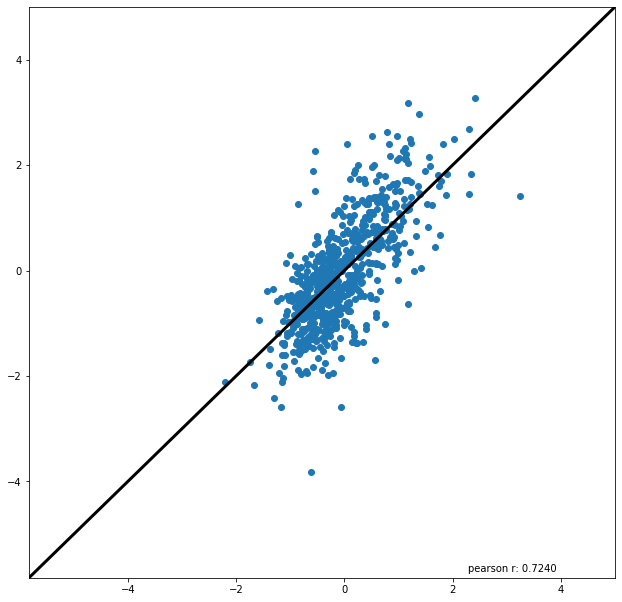

In [11]:
fig = plt.figure()
fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)

ax.scatter(mean.numpy(),y_test)
y_max = int(y_test.max())+2
y_min = y_test.min()-2
ax.set_xlim(y_min,y_max)
ax.set_ylim(y_min,y_max)

x = np.linspace(*ax.get_xlim())
# ax.plot([0,1],[0,1], transform=ax.transAxes)
ax.plot(x, x,color='k',linewidth=3)

pearson = scipy.stats.pearsonr(y_test.squeeze(),mean.numpy().squeeze())[0]
ax.text(.75,.01,f'pearson r: {pearson:.4f}',transform=ax.transAxes)

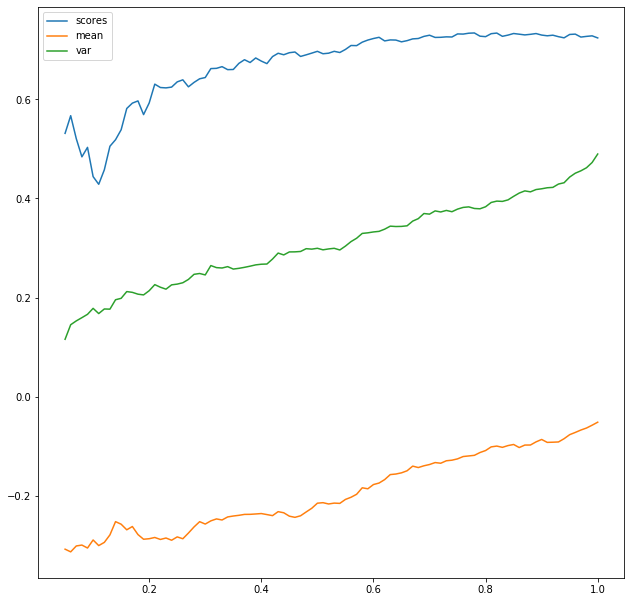

In [12]:
#plot mse, smse, and pearsonr for top 10% lowest variance to all, compute every 5% increments
sorted_indicies = np.argsort(var.numpy().squeeze())
sorted_mean = mean.numpy()[sorted_indicies]
sorted_ytruth = y_test[sorted_indicies]
sorted_var = var.numpy()[sorted_indicies]

scores=[]
percent_var=[]
percent_mean=[]

intervals = np.arange(.05,1.01,0.01)
for percent in intervals:
    index = int(np.floor(sorted_mean.shape[0]*percent))
    top_means = sorted_mean[0:index]
    percent_mean.append(top_means.mean())
    percent_var.append(top_means.var())
    top_means_ytruth = sorted_ytruth[0:index]
    scores.append(compute_metrics(top_means, top_means_ytruth, y_train, fc_scale=2)['pearsonr'])
    #print(metrics.mean_squared_error(top_means_ytruth,top_means))
    
fig = plt.figure()
fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)
ax.plot(intervals,scores,label='scores')
ax.plot(intervals,percent_mean,label='mean')
ax.plot(intervals,percent_var,label='var')
ax.legend()

### Generate full model to use for inference

In [13]:
train = rna_prot_embed['AT2_04M_F0'].copy()

train_z,_,means,stds = zscore(train,train,return_means=True)
x_train = train_z.drop(columns='ProteinAUC').values
y_train = train_z[['ProteinAUC']].values

k = gpflow.kernels.Matern52(lengthscale=[1]*x_train.shape[1])

m = gpflow.models.GPR(data=(x_train, y_train), kernel=k, mean_function=None)
m.likelihood.variance.assign(0.1)

opt = gpflow.optimizers.Scipy()

def objective_closure():
    return - m.log_marginal_likelihood()

print('Optimizing')
opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=150))

Optimizing


In [14]:
mean, var = m.predict_f(x_train)
metrics = compute_metrics(mean.numpy(), y_train, y_train, fc_scale=2)
metrics['loss'] = opt_logs.fun
metrics

{'mae': 0.5091065195164636,
 'mse': 0.45109902151032105,
 'smse': 0.4512264506124426,
 'r2': 0.5487735493875574,
 'evs': 0.5487739226900421,
 'spearmanrho': 0.7062128690634599,
 'spearmanrho_p': 0.0,
 'pearsonr': 0.74281469037706,
 'pearsonr_p': 0.0,
 'median_abs_fc': 1.3175264386486103,
 'mean_abs_fc': 1.4231685351577972,
 'loss': 3995.669071335992}

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7effb34f4710>]],
      dtype=object)

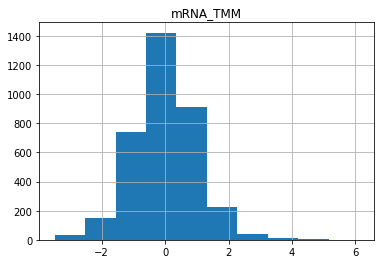

In [15]:
train_z.hist('mRNA_TMM')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7eff6c2a5150>]],
      dtype=object)

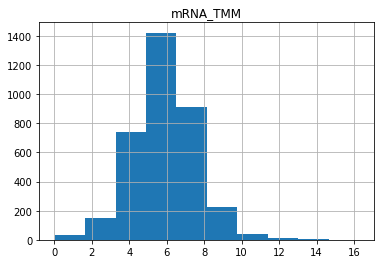

In [16]:
train.hist('mRNA_TMM')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7effb2f59c10>]],
      dtype=object)

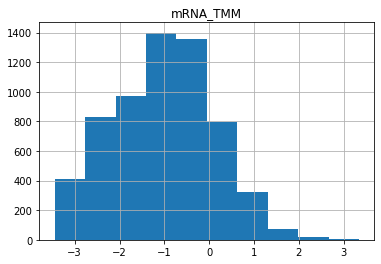

In [31]:
infer.hist(column='mRNA_TMM')

In [28]:
infer = rna_missing_prot_embed['AM_04M_F0'][['AM_04M_F0','seq_length']+list(range(64))].copy()
infer.rename(columns={'AM_04M_F0': 'mRNA_TMM', 'seq_length': 'ProteinLength'},inplace=True)

#zscore using mean and std from train
infer = (infer-means[means.index!='ProteinAUC'])/stds[stds.index!='ProteinAUC']
x_infer = infer.values
mean_inf, var_inf = m.predict_f(x_infer)

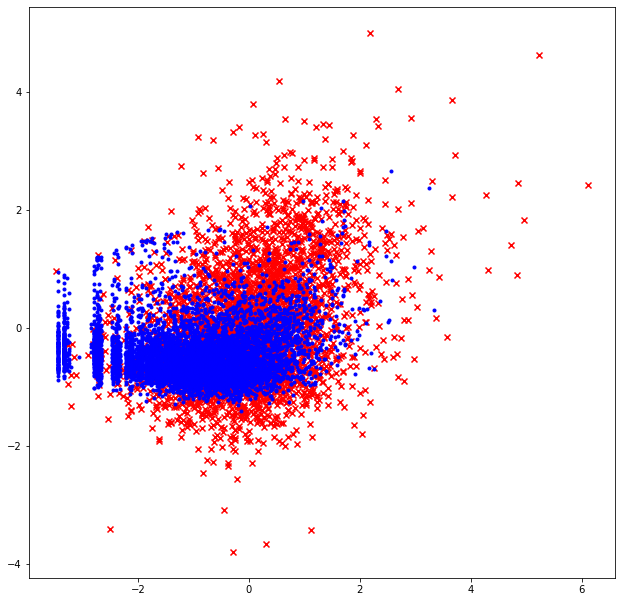

In [29]:
fig = plt.figure()
fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)

ax.scatter(x_train[:,0],y_train,marker='x',color='r')
ax.scatter(x_infer[:,0],mean_inf.numpy(),marker='.',color='b')

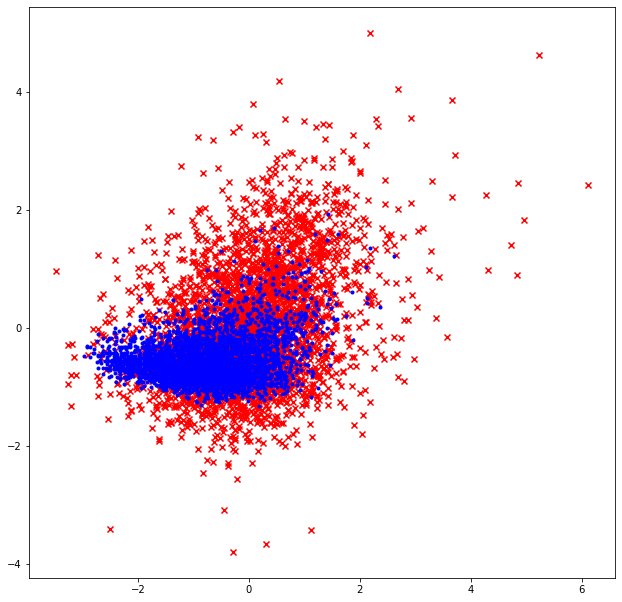

In [21]:
sorted_indicies = np.argsort(var_inf.numpy().squeeze())
sorted_x_infer = x_infer[sorted_indicies,0]
sorted_mean = mean_inf.numpy()[sorted_indicies]
sorted_var = var_inf.numpy()[sorted_indicies]

percent=0.5
lower_percent=0

index = int(np.floor(sorted_mean.shape[0]*percent))
lower_index = int(np.floor(sorted_mean.shape[0]*lower_percent))

top_means = sorted_mean[lower_index:index]
top_xinfer = sorted_x_infer[lower_index:index]

fig = plt.figure()
fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)

ax.scatter(x_train[:,0],y_train,marker='x',color='r')
ax.scatter(top_xinfer,top_means,marker='.',color='b')

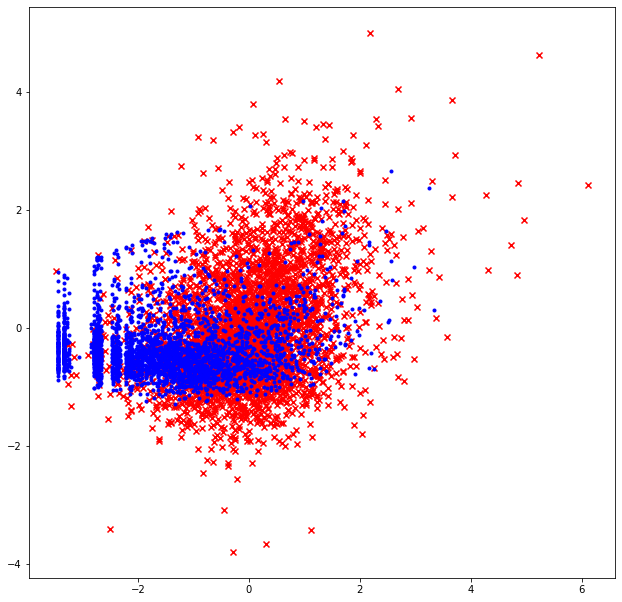

In [32]:
sorted_indicies = np.argsort(var_inf.numpy().squeeze())
sorted_x_infer = x_infer[sorted_indicies,0]
sorted_mean = mean_inf.numpy()[sorted_indicies]
sorted_var = var_inf.numpy()[sorted_indicies]

percent=1
lower_percent=0.5

index = int(np.floor(sorted_mean.shape[0]*percent))
lower_index = int(np.floor(sorted_mean.shape[0]*lower_percent))

top_means = sorted_mean[lower_index:index]
top_xinfer = sorted_x_infer[lower_index:index]

fig = plt.figure()
fig.set_size_inches(10.5,10.5)
ax = fig.add_subplot(111)

ax.scatter(x_train[:,0],y_train,marker='x',color='r')
ax.scatter(top_xinfer,top_means,marker='.',color='b')

In [23]:
positions_missing = rna_missing_prot_embed['AT2_04M_F0']['AvgChrs']

In [24]:
positions_missing

Row.names
ENSMUSG00000000028    15.191392
ENSMUSG00000000056    10.993152
ENSMUSG00000000058     5.115437
ENSMUSG00000000078    12.048712
ENSMUSG00000000085     3.769722
                        ...    
ENSMUSG00000103897    17.416568
ENSMUSG00000103906    14.729618
ENSMUSG00000104063    17.416710
ENSMUSG00000104346    17.416284
ENSMUSG00000104445     2.551418
Name: AvgChrs, Length: 7335, dtype: float64

In [25]:
positions['AT2_04M_F0']

,,,AvgChrs
Gene.names,Majority.protein.IDs,cell,
Gnai3,Q9DC51,AT2_04M_F0,2.675624
Cox5a,P12787,AT2_04M_F0,8.461710
Dlat,Q8BMF4,AT2_04M_F0,8.406494
Gpr107,Q8BUV8,AT2_04M_F0,1.171243
Trim25,Q61510,AT2_04M_F0,10.729096
...,...,...,...
H1f0,P10922,AT2_04M_F0,14.759580
Psmb9,P28076,AT2_04M_F0,16.359889
Sowahc,Q8C0J6,AT2_04M_F0,9.453148


In [26]:
rna_prot_embed['AT2_04M_F0']

,,,mRNA_TMM,ProteinAUC,ProteinLength,0,1,2,3,4,5,6,...,54,55,56,57,58,59,60,61,62,63
Gene.names,Majority.protein.IDs,cell,,,,,,,,,,,,,,,,,,,,,
Gnai3,Q9DC51,AT2_04M_F0,7.151432,25.389750,8.471675,-0.123134,0.126303,-0.092475,-0.969833,-0.005820,-0.057672,0.107903,...,0.137047,0.008167,-0.088351,-0.018563,-0.036717,0.443771,-0.123508,-0.036990,0.424119,0.014253
Cox5a,P12787,AT2_04M_F0,5.426985,29.676180,7.199672,0.014350,0.121865,-0.062778,-0.984908,-0.017123,-0.065598,0.056624,...,0.118580,0.009217,0.136575,-0.059452,0.019777,0.423250,-0.063350,-0.025512,0.384949,0.015145
Dlat,Q8BMF4,AT2_04M_F0,5.496820,26.982080,9.328675,-0.026584,0.109657,-0.081645,-0.963428,-0.030461,-0.162972,0.066631,...,0.138321,0.016578,0.122076,-0.143501,0.013228,0.302376,-0.168613,-0.036329,0.351341,-0.014426
Gpr107,Q8BUV8,AT2_04M_F0,6.244449,22.902280,9.108524,-0.027330,0.104179,0.021283,-0.953025,-0.020908,-0.239551,0.096819,...,0.127384,0.011998,0.039601,-0.030980,-0.080105,0.244611,-0.092342,-0.039188,0.482943,-0.018493
Trim25,Q61510,AT2_04M_F0,6.358683,24.415022,9.310613,-0.071294,0.072918,-0.114657,-0.975195,-0.041038,-0.088154,0.031005,...,0.156678,0.041194,0.020387,-0.059393,-0.025968,0.263505,-0.113366,-0.038602,0.264744,0.012638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H1f0,P10922,AT2_04M_F0,7.419878,28.773797,7.607330,-0.225748,0.043310,-0.087645,-0.958192,-0.016585,-0.014059,0.020144,...,0.172665,-0.047817,0.058236,-0.358728,0.072748,0.262859,-0.376427,-0.060751,0.199526,0.070703
Psmb9,P28076,AT2_04M_F0,3.389854,24.962038,7.781360,0.008655,0.161174,-0.095418,-0.960228,-0.001615,-0.221773,0.072014,...,0.086866,0.005392,0.017854,-0.061520,-0.005442,0.363715,-0.135031,-0.037465,0.440352,-0.036961
Sowahc,Q8C0J6,AT2_04M_F0,0.555332,23.859992,9.002815,-0.048821,0.106069,-0.109359,-0.970515,-0.047805,-0.196038,0.059995,...,0.202381,0.039076,0.152250,-0.110805,0.024184,0.343852,-0.138716,-0.007629,0.205146,0.000572
